### Rationale for Selected Approach.

After reading Wendy Chapman et.al's "Evaluation of Negation Phrases in Narrative Clinical Reports", Eduardo Blanco's & Dan Moldovan's "Some Issues on Detecting Negation from Text", and Sergey Goryachev et.al's "Implementation and Evaluation of Four Different Methods of Negation Detection", I resolved to use the NegEx algorithm to identify negation.

high accuracy, or degree of closeness of measurement to the true value, and Kappa statistic scores, which measures the inter-rater agreement for categorical items.

From the literature, the NegEx algorithm (and NegExpander) seemed to provide a consistently higher classification accuracy (degree of closeness of measurement to the true value), Kappa statistic (measures the inter-rater agreement for categorical items), sensitivity, and precision, and lower standard error than other methods (SVM, Naive bayes). The NegEx and NegExpander algorithms perform well with sentences that contain UMLS terms and identifying negation statuses assigned to each UMLS term. Assuming that the words 'condition' words in the data are mostly UMLS words, I reasoned that NegEx would be a good algorithm to explore.

### Comments about performance. How well it works?
The NegEx algorithm, obtained from Chapman's github page (https://github.com/chapmanbe/negex), provided the following results:
    
    
    Percentage correct: 0.972
    runtime: 6.45 seconds
    

Interestingly, after applying both Chapman's sample data and the Lexigram data, I realized the data and results were the same among the two (same) datasets. Therefore, I decided to deepend my understanding of the NegEx results and wonder, 'out of all the medical text used, what medical concepts (ie - condition) did NegEx associate with the most common negation tags'? 

For instance, I wanted to observe how 'nausea' was being negated, are doctors using 'no', 'denies', 'absent', or other terms to commonly refer to a certain medical concept.

Answering this question required some fair data cleaning of sentences to accurately identify NegEx tags and words.

### Data insights. What did you learn from working with this dataset?

I learned the following:
1. 'no', or a phrases using 'no', are the most commonly used negation phrases among these medical notes.
2. NegEx often identifies only 1 negation term per medical concept. But sometimes it identifies multiple negations per medical term. This may be dangerous as other negation terms may be negating' another medical concept. Otherwise, the NegEx algorithm performs relatively well.
3. For the most part, NegEx only identifies 1 negation per medical concept. This may be a result of the algorithm or actually how medical notes are being written.
4. The data is quite messy, which involved lots of special data manipulation to aggregate all sentences and obtain the correct tagging. 

### A comment in terms of potential iterations/future work if given more time.
Additional research could identify what is the context of the sentence, such as whether the negation is subjective ("patient denies feeling nausea") or objective ("patient has no nausea"). Perhaps through training, medical notes are standardized by using certain words to negate subjective and objective findings. Mapping how words are used can provide insight into how the hospital or certain doctors are using certain terminology.

Furthermore, it would be worth looking at negation words among correctly and incorrectly classified sentences to see if there's a reason why NegEx incorrectly classifies certain words.

# Code below

Code Table of Contents:
1. Import Python Modules/Packages
2. Import Data
3. Explore Data
4. Apply NegEx Algorithm. Get results
2. Parse NegEx results to get all tags with words in the middle of tags (and ignoring non-tagged square brackets)
3. Analyze & send to manuel

#### 1. Import Modules

In [1]:
import csv
import pandas as pd
#import github : pip install git+https://github.com/...
from daj import daj   #https://github.com/Yomguithereal/python-daj
import timeit
import time
import re
exec(open("negex.py").read())  #negex algorithm
import csv
from collections import Counter
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('jberthet', 'zcl6t30m4c')
from collections import Counter

#Random Forest
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, zero_one_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import tree

%matplotlib inline

#### 2. Import data

In [2]:
data = daj.tsv < "annotations-medical.tsv"

#### 3. Explore data

Look at Experiencer, Negation Status, and Temporality

In [3]:
# Get all lists that have certain Experiencer value in list
df = []
def experiencerTxt(word):
    for i in list(range(0,len(data) - 1)):
        if word in data[i][5]:
            df.append(data[i])
    return df
experiencerTxt("Family member")    #Patient, Family member, Other

[['583',
  'colon polyps',
  'FH is +ve for a  sister with COLON POLYPS at age **AGE[in 60s] who is under colonoscopic surveillance.',
  'Affirmed',
  'Historical',
  'Family member'],
 ['698',
  'colon cancer',
  "The indication for this procedure is family  history of COLON CANCER (father in his early 70's) and a personal history of  adenomatous polyps (***PATH-NUMBER[1]).",
  'Affirmed',
  'Historical',
  'Family member'],
 ['1192',
  'colon cancer',
  'The indication for this procedure is family  history of COLON CANCER.',
  'Affirmed',
  'Historical',
  'Family member'],
 ['2106',
  'colon polyps',
  'The indication for this procedure is family  history of COLON POLYPS and screening.',
  'Affirmed',
  'Historical',
  'Family member']]

In [4]:
# Get all lists that have certain Negation Status value in list
def negationTxt(word):
    df = []
    for i in list(range(0,len(data) - 1)):
        if word in data[i][3]:
            df.append(data[i])
    return df

print("There are %s Affirmed" % (len(negationTxt("Affirmed"))))
print("There are %s Negated" % (len(negationTxt("Negated")))) 

There are 1884 Affirmed
There are 491 Negated


In [5]:
# Get all lists that have certain Temporality value in list
def temporalityTxt(word):
    df = []
    for i in list(range(0,len(data) - 1)):
        if word in data[i][4]:
            df.append(data[i])
    return df

print("There are %s Recent" % (len(temporalityTxt("Recent"))))
print("There are %s Historical" % (len(temporalityTxt("Historical"))))
print("There are %s Not particular" % (len(temporalityTxt("Not particular"))))

There are 2062 Recent
There are 257 Historical
There are 56 Not particular


#### 4. Apply NegEx Algorithm. Get results

NOTE: I applied both the example in Chapman's github and the Lexigram data and found the data to be the same because NegEx gave the exact same results in both data sets. 

Splitting the data into a train and test set before implementing a function/algorithm is only useful if you can tune the algorithm by some parameter like a transformation of the data to affect distribution, or penalization parameter in regularization, or prune trees in ensemble methods, to adjusting weights in neural network type models.

For NegEx, I found that there were no parameters that could be adjusted (or cross validated) on. The only tuning is within the negex_triggers, which numerous physicians created due to their individual tagging and years of experience. Therefore, I did not touch the negex_trigger. (However, it would be interesting to adjust the triggers to see how the algorithm works with different medical texts.)

#plot correct words
Since the histogram for correctly labeled values is a bit short, I plotted some values in Plot.ly 
Viewable here: https://plot.ly/~jberthet/3/

Chapman's data 

In [6]:
#Get first 4 parts of list to mimic negex input data.
testdf = [item[0:4] for item in data]

#grab each row
negexInput = []
for i in list(range(0, len(testdf))):
    testString = '   '.join(testdf[i])
    negexInput.append(testString)

#Write into text file
lexigramFile = open('LexiGram4Negex.txt', 'w')
for item in negexInput:
    lexigramFile.write("%s \t\n" % item)

Lexigram data

NegEx Algorithm

In [7]:
####NegEx Algorithm
start = time.time()
# def main():
rfile = open(r'negex_triggers.txt')
irules = sortRules(rfile.readlines())
reportNum = 0
correctNum = 0
ofile = open(r'Lexigram_output.txt', 'w')
output = []
outputfile = csv.writer(ofile, delimiter = '\t')
for report in testdf:
    tagger = negTagger(sentence = report[2],
                       phrases = [report[1]],
                       rules = irules,
                       negP=False)
    report.append(tagger.getNegTaggedSentence())
    report.append(tagger.getNegationFlag())
    report = report + tagger.getScopes()
    reportNum += 1
    if report[3].lower() == report[5]:
        correctNum +=1
    output.append(report)
outputfile.writerow(['Percentage correct:', float(correctNum)/float(reportNum)])
for row in output:
    if row:
        outputfile.writerow(row)
print("Percentage correct: %s " % (float(correctNum)/float(reportNum)))
ofile.close()

# if __name__ == '__main__': main()

end = time.time()
print("runtime: %s seconds" % (end - start))  

#variables to use later
rfile = open(r'negex_triggers.txt')
irules = sortRules(rfile.readlines())

Percentage correct: 0.9722222222222222 
runtime: 7.141714096069336 seconds


#### 5. Explore results. Parse data to get all negated words and their associated tags

Plot

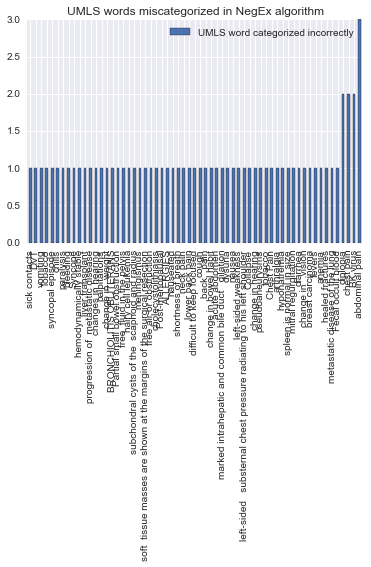

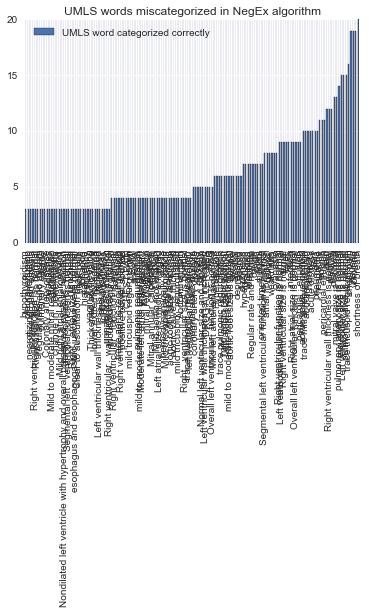

In [8]:
#Explore Distributions of Data
#Find UMLS negex False Positive (Incorrect)
df_incorrect = []
for i in output:
    if i[3].lower() != i[5]:
        df_incorrect.append(i[1])

#Find UMLS negex True Positive (Correct)
df_correct = []
for i in output:
    if i[3].lower() == i[5]:
        df_correct.append(i[1])

#plot incorrect words
df2_incorrect = Counter(df_incorrect)
df3_incorrect = pd.DataFrame.from_dict(df2_incorrect, orient='index').sort_values(0)
df3_incorrect.columns = ["UMLS word categorized incorrectly"]
df3_incorrect.plot(kind = "bar", legend = True, orientation = 'vertical',title = "UMLS words miscategorized in NegEx algorithm")
pl.show()

#plot correct words
df2_correct = Counter(df_correct)   #Count # of words correctly labeled
df3_correct = pd.DataFrame.from_dict(df2_correct, orient='index').sort_values(0) #put in dataframe for plotting
df3_correct.columns = ["UMLS word categorized correctly"]  #rename column
df4_correct = df3_correct.loc[df3_correct["UMLS word categorized correctly"] > 2]  #filter 1-time words
df4_correct.plot(kind = "bar", legend = True, orientation = 'vertical',title = "UMLS words miscategorized in NegEx algorithm")
# df3_correct.plot(kind = "hist", legend = True, orientation = 'vertical',title = "UMLS words miscategorized in NegEx algorithm")
pl.show()

# #plot correct words
#SincePlotly https://plot.ly/~jberthet/3/

In [9]:
#get every trigger in list of list
irule_listolist = []
for i in list(range(0, len(irules))):
    irule_listolist.extend([(irules[i][0],irules[i][2])])
    
#get every trigger in big string
irule_list = []
for i in list(range(0, len(irules))):
    irule_list.extend((irules[i][0],irules[i][2]))  #similar to append

#Get unique tag values, plus [NEGATED]
unique_tags = []
for i in list(range(0, len(irule_listolist))):
    unique_tags.append(irule_listolist[i][1])
unique_tags2 = list(set(unique_tags))
unique_tags2.extend(['[NEGATED]', '[PHRASE]'])  
unique_tags_str = re.compile('|'.join(unique_tags2))

#Get only values that exist in unique_tags2
def remove_bracket(s):
    return s[1:-1]
unique_tags_noBracket = [remove_bracket(s) for s in unique_tags2]

#Replace keys with values: https://gomputor.wordpress.com/2008/09/27/search-replace-multiple-words-or-characters-with-python/
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

# WORKS: Get all tags with words in the middle of tags
allWordTags = []  #final output
df_final = []
for i in list(range(0, len(output))):
    #Find values within square brackets that don't exist in tags & replace brackets with spaces.
    df1 = re.findall(r'\[(.*?)\]', output[i][4])  #all words in sq brackets, listed w/out []
    #Create Dictionary used in replace_all()
    df = {}
    for p in df1:
        #if p is not a tagged word, then remove it's square brackets
        if p not in unique_tags_noBracket:    
            remove_str = "{0}{1}{2}".format("[", p, "]")   
            for q in remove_str:
                df[remove_str] = p
        final_sentence = replace_all(output[i][4], df) 
    df_final.append(final_sentence)
#     Get all appropriate [tag]word[tag]
    reg =   r'(\[\w+\].+?\[\w+\])'
    s = df_final[i]
    match = re.findall(reg, s)
    allWordTags.append(match)
    allWordTags
allWordTags[1:5]

[['[PREN]no[PREN]', '[NEGATED]EDEMA[NEGATED]'],
 ['[PHRASE]HYPERTENSION[PHRASE]'],
 ['[PHRASE]OSTEOCHONDRAL IRREGULARITY IS IDENTIFIED WITHIN THE 45 DEGREE FLEXION ZONE OF THE LATERAL FEMORAL CONDYLES[PHRASE]'],
 ['[PREN]no[PREN]', '[NEGATED]RALES[NEGATED]']]

#### 6. Get frequency of tags and their associated negation terms. 
#### For each unique medical concept among all the medical text, count the number of times a tag is used for the corresponding negated term 

In other words, for every time a tagged word shows up, place all sentences into one big string and count the number of times tags show up and corresponding negation terms. This provides frequency of both negation terms and conditions being negated. 

**This result provides a glimpse as to the terminology often used to negate certain medical words.

In detail: print out a list of lists that counts the number of times NegEx Tags and Words appeared, by main medical concept
in sentences, throughout all the medical notes.
Each list is the product of attaching all the sentences that have the main medical concept and counting 
the number of times tags and words appear. 

In [10]:
#Create a dictionary of words from each string in list: 
#ex: [PREN]no[PREN] [NEGATED]EDEMA[NEGATED]' -> PREN: no, NEGATED:EDEMA
def word_count(string):
    my_string = string.lower().split()
    my_dict = {}
    for item in my_string:
        if item in my_dict:
            my_dict[item] += 1
        else:
            my_dict[item] = 1
    print(my_dict)

#Convert list of list to string: Turn each sentence from a list to a string
def List2String_Magic(ListOLists):
    List2String_df = []
    for i in ListOLists:
        s = ':'.join(i)
        List2String_df.append(s)
    return List2String_df

#get incorrect classifications
df_incorrect = []
for i in output:
    if i[3].lower() != i[5]:
        df_incorrect.append(i[1])

#Get Only Negated Terms
All_Negated = []
for i in list(range(0, len(allWordTags))):
    for p in list(range(0, len(allWordTags[i]))):
        if '[NEGATED]' in allWordTags[i][p]:   #get all lists with Negated status
            All_Negated.append(allWordTags[i])
    All_Negated

#Turn each List into big string for all Negated Terms to search for unique words within strings
List2String = []
for i in All_Negated:
    s = ' '.join(i)
    List2String.append(s)
List2String

#Get unique list of negated terms with NEGATED:Term
uniqueNegWords = []
df = []
for i in list(range(0, len(List2String))):
    if "NEGATED" in List2String[i]:   
        NEGATED = re.findall("\[(NEGATED)\](.*?)\[", List2String[i])
        NEGATED2 = List2String_Magic(NEGATED)    #Put List into String
        NEGATED3 = ' '.join(NEGATED2)
        NEGATED4 = NEGATED3.split(":", 1)[-1]
        df.append(NEGATED4)
uniqueNegWords2 = list(set(df))

#Get Tag:Word for all sentences
all_sentence_per_neg = []
for p in uniqueNegWords2:    #['PARESTHESIA','RALES',...]
    sentence_per_neg = []
    for i in List2String:                         #[PREN]no[PREN] [NEGATED]MENINGISMUS[NEGATED]',
        df2 = re.findall("\[(\w+)\](.*?)\[", i)   #[('PREN', 'no'), ('NEGATED', 'MENINGISMUS')]
        df3 = List2String_Magic(df2)              #['PREN:no', 'NEGATED:MENINGISMUS']
        df4 = '---'.join(df3)                     #'PREN:no NEGATED:MENINGISMUS'
        if p in df4:
            sentence_per_neg.append(df4)
            all_sentence_per_neg.insert(0, sentence_per_neg)
# :D Per negated word, got all negated sentences and put them into list, so to count  
unique_data = [list(x) for x in set(tuple(x) for x in all_sentence_per_neg)] 

#Print out a list of lists that counts the number of times NegEx Tags and Words appeared, by main medical concept
# in sentences, throughout all the medical notes.
#Each list is the product of attaching all the sentences that have the main medical concept and counting 
# the number of times 
ud_final = []
for i in unique_data:
    ud1 = str(i[0]).split("---")
    ud2 = Counter(ud1)
    ud_final.append(ud2)
ud_final[0:15]

[Counter({'NEGATED:HEMATURIA': 1, 'PREN:denies': 1, 'PREN:no': 13}),
 Counter({'NEGATED:PARAESTHESIAS': 1, 'PREN:denied': 1}),
 Counter({'NEGATED:DIFFICULTY HEARING': 1, 'PREN:no': 1}),
 Counter({'NEGATED:DISCRETE HEPATIC LESIONS': 1, 'PREN:no': 1}),
 Counter({'NEGATED:COLLAPSE': 1, 'PREN:not': 1}),
 Counter({'NEGATED:VEGETATIONS': 1, 'PREN:no': 1}),
 Counter({'NEGATED:HEPATOSPLENOMEGALY': 1, 'PREN:no': 1}),
 Counter({'CONJ:however': 1,
          'NEGATED:HEMODYNAMICALLY STABLE': 1,
          'PREN:no evidence': 1}),
 Counter({'NEGATED:STRESS INDUCED CHEST PAIN': 1, 'PREN:no': 1}),
 Counter({'NEGATED:HEADACHES': 1, 'PREN:denies': 1}),
 Counter({'NEGATED:APPARENT DISTRESS': 1, 'PREN:no': 1}),
 Counter({'NEGATED:INTRACRANIAL HEMORRHAGE': 1, 'PREN:no': 1}),
 Counter({'NEGATED:ILLICIT DRUG USE': 1, 'PREN:denies': 1}),
 Counter({'NEGATED:CHANGE IN SLEEP': 1, 'PREN:denies': 1}),
 Counter({'NEGATED:PERICARDIAL EFFUSION': 1, 'PREN:no': 1})]

#### 7. Plot the frequency of negation terms for an example medical term

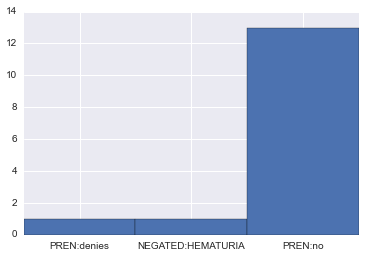

In [11]:
#Plot frequency of tags by various negated medical terms
labels, values = zip(*ud_final[0].items())
indexes = np.arange(len(labels))
width = 1
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

Plot Conclusion: Within all the medical text, the NegEx algorithm found that the medical term 'HEMATURIA' was negated with 'no' 13 times and with 'denies' 1 time.  